[[0.0087265  0.0021017 ]
 [0.0021017  0.00321106]] 

[[ 6.84736091e-04 -2.20467544e-38]
 [ 2.14096052e-38  6.84736091e-04]] 

[[-0.31358134]
 [-0.07926368]] 

[[-1.89478358e-16]
 [-5.63887071e-18]] 

[[-0.31358134]
 [-0.07926368]] 

Tiempo de ejecución:  0.3963150978088379  segundos
Plots:



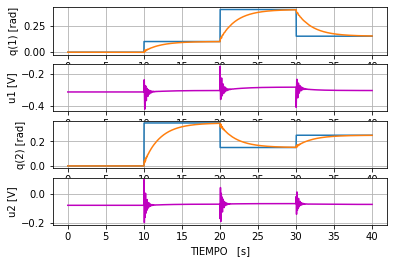

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import time
# CONTROL ADAPTATIVO PARA ROBOT DE 2GDL
# FUNCION DE CONTROL ADAPTATIVO QUE DEVUELVE LAS SENALES DE LAS 2
# ARTICULACIONES, SENALES DE CONTROL Y POSICION
# LAS ENTRADAS SON LOS PARAMETROS DE SINTONIZACION
# Lambda=5 ld = 80 Kd = 20 Gamma = 0.01#tap=1
Lambda=0.5
ld = 8
Kd = 1
Gamma = 0.008
#tap=1
u_lim=2.2
# PARAMETROS DE CONTROL
# I = [1 0 0 00 1 0 00 0 1 00 0 0 1]
I = np.eye(2,2)
Ld = ld*I
# DATOS DEL SUB-SISTEMA MECANICO
# Masas
m3=0.135
m4=0.236
#Longitudes
l3_y=0.0933
L3_y=0.124
l4_y=0.060
L4_y=0.126
# Inercias
Ixx3=1358961*1e-09
Iyy3=1350228*1e-09
Izz3=24835*1e-09
Ixx4=1128335*1e-09
Iyy4=1077791*1e-09
Izz4=182774*1e-09
Bm=0.0001
Bg=0.01
#   n=353.5 g=9.81
n=350.5
g=9.81
Jm=0.0000071
Jg=0.0000053
#   Jeq=(n**2)*Jm+JgBeq=(n**2)*Bm+Bg
Jeq=0.0037
Beq=0.0012

# DATOS DEL SUB-SISTEMA ELECTRICO
#   Km=0.0458 Kb=0.0458 KA=8.5 Ra=2.49Ka=8.5
Km=0.005
Kb=1
KA=1
Ra=1
Ka=1

# Keq=Beq+(n**2)*Km*Kb/Ra

# CONDICIONES INICIALES
# VALORES INICIALES
q = np.array([[np.deg2rad(0)], [np.deg2rad(0)]], dtype=np.float64)
dq = np.array([[0], [0]], dtype=np.float64)
qe= np.array([[np.deg2rad(0)], [np.deg2rad(0)]], dtype=np.float64) 
dqe=np.array([[0], [0]], dtype=np.float64)
dqd = np.array([[0], [0]], dtype=np.float64)
ddqd =  np.array([[0], [0]], dtype=np.float64)
qd=np.array([[0], [0]], dtype=np.float64)
qtilde = np.array([[0], [0]], dtype=np.float64)
dqr = np.array([[np.deg2rad(0)], [np.deg2rad(0)]], dtype=np.float64)
ddqr =  np.array([[0], [0]], dtype=np.float64)
s =  np.array([[0], [0]], dtype=np.float64)
dqtilde =  np.array([[0], [0]], dtype=np.float64)
# print("dqe:\n")
# print(dqe)
# print("\n")
U_lin=1/(Km*n)
a1=m3*l3_y**2+Iyy3+Iyy4+m4*(L3_y**2+l4_y**2)
a2=m4*L3_y*l4_y
a3=Jeq
a4=Beq
a5=Iyy4+m4*l4_y**2
a6=m4*L3_y+m3*l3_y
a7=m4*l4_y
ae=U_lin*np.array([[a1],[a2],[a3],[a4],[a5],[a6],[a7]])
u_pas=np.array([[0], [0]])
# print("ae:\n")
# print(ae)
# print("\n")
# LAZO DE CONTROL
T = 0.01
Tp = 5
A = 0.5
W = 2*np.pi*T/Tp   
nn = 4000

# VARIABLES PARA ALMACENAR DATOS
Q1=np.zeros((1,nn), dtype=np.float64)
Qd1=np.zeros((1,nn), dtype=np.float64)
U1=np.zeros((1,nn), dtype=np.float64)
Q2=np.zeros((1,nn), dtype=np.float64)
Qd2=np.zeros((1,nn), dtype=np.float64)
U2=np.zeros((1,nn), dtype=np.float64)
Q=np.zeros((2,nn), dtype=np.float64)
# print("dqe:\n")
# print(dqe)
# print("\n")

start_time = time.time()
# LAZO DE CONTROL
for k in np.arange(0, nn):

    # REFERENCIAS DESEADAS
#     qd_temp = np.copy(qd)
    if k >= 0 and k <= nn/4:
        qd[0,0] = 0*A
        qd[1,0] = 0*A
    elif k >= nn/4 and k <= nn/2:
        qd[0,0] = 0.2*A
        qd[1,0] = 0.7*A
    elif k >= nn/2 and k <= 3*nn/4:
        qd[0,0] = 0.8*A
        qd[1,0] = 0.3*A
    elif k >= 3*nn/4 and k <= nn:
        qd[0,0] = 0.3*A
        qd[1,0] = 0.5*A
#     np.copyto(qd, qd_temp)

#     print("qd:\n")
#     print(qd)
#     print("\n")
    Qd1_temp = np.copy(Qd1)
    Qd2_temp = np.copy(Qd2)
    dqd_temp = np.copy(dqd)
    ddqd_temp = np.copy(ddqd)

    Qd1_temp[0,k]=qd[0,0]
    Qd2_temp[0,k]=qd[1,0]
    dqd_temp[0]=0
    dqd_temp[1]=0
    ddqd_temp[0]=0
    ddqd_temp[1]=0
    np.copyto(Qd1,Qd1_temp)
    np.copyto(Qd2,Qd2_temp)
    np.copyto(dqd,dqd_temp)
    np.copyto(ddqd,ddqd_temp)


    # OBSERVADOR DE VELOCIDAD
    dqe = dqd + Ld@(q - qe)
    qe = qe + T*dqe
    
    # ERROR DE POSICION Y DE VELOCIDAD   
    #print("dqe:\n")
    #print(dqe)
    #print("\n")
    qtilde = q - qd
    dqtilde = dqe - dqd

    # FUNCION DE DESLIZAMIENTO 
    s = dqtilde + Lambda*qtilde

    # VELOCIDAD Y ACELERACION DE REFERENCIA
    dqr = dqd - Lambda*qtilde
    ddqr = ddqd - Lambda*dqtilde

    # MATRIZ Y
    Y11=ddqr[0,0]

    Y12=np.cos(qe[1,0])*(2*ddqr[0,0]+ddqr[1,0])-np.sin(qe[1,0])*(2*dqr[0,0]*dqr[1,0]+dqr[1,0]**2)
    Y13=ddqr[0,0]
    Y14=dqr[0,0]
    Y15=ddqr[1,0]
    Y16=-g*np.cos(qe[0,0])
    Y17=-g*np.cos(qe[0,0]+qe[1,0])
    Y21=0
    Y22=np.cos(qe[1,0])*ddqr[0,0]+np.sin(qe[1,0])*dqr[0,0]**2
    Y23=ddqr[1,0]
    Y24=dqr[1,0]
    Y25=ddqr[0,0]+ddqr[1,0]
    Y26=0
    Y27=-g*np.cos(qe[0,0]+qe[1,0])

    Y = np.array([[Y11, Y12, Y13, Y14, Y15, Y16, Y17],
                [Y21, Y22, Y23, Y24, Y25, Y26, Y27]])


    # ESTIMACION DE PARAMETROS
    Y_trans = np.transpose(Y) 

    ae = ae - T*Gamma*Y_trans@s

    # LEY DE CONTROL 
    u=Y@ae-Kd*s

    # Limitador de corriente:
    if u[0] > u_lim or u[0] < -u_lim:
        u[0] = u_pas[0]
    else:
        u_pas[0] = u[0]

    if u[1] > u_lim or u[1] < -u_lim:
        u[1] = u_pas[1]
    else:
        u_pas[1] = u[1]
    #Almacenar variables de control:
#     print("K:\n")
#     print(k)
#     print("\n")
#     print("u:\n")
#     print(u)
#     print("\n")
    U1_temp = np.copy(U1)
    U2_temp = np.copy(U2)
    U1_temp[0,k]=u[0,0]
    U2_temp[0,k]=u[1,0]
    np.copyto(U1,U1_temp)
    np.copyto(U2,U2_temp)


    # MODELO DINAMICO DEL SISTEMA 
    M11 = U_lin*(Iyy3 + Iyy4 + Jeq + m4*(L3_y**2 + 2*np.cos(q[1,0])*L3_y*l4_y + l4_y**2) + l3_y**2*m3)
    M12 = U_lin*(Iyy4 + m4*(l4_y**2 + L3_y*np.cos(q[1,0])*l4_y))
    M21 = M12
    M22 = U_lin*(m4*l4_y**2 + Iyy4 + Jeq)
    M   = np.array([[M11, M12],
                  [M21, M22]])
    #######
    P11 = U_lin*(Beq - L3_y*l4_y*m4*dq[1,0]*np.sin(q[1,0]))
    P12 = U_lin*(-L3_y*l4_y*m4*np.sin(q[1,0])*(dq[0,0] + dq[1,0]))
    P21 = U_lin*(L3_y*l4_y*m4*dq[0,0]*np.sin(q[1,0]))
    P22 = U_lin*(Beq)

    P   = np.array([[P11, P12],
              [P21, P22]])

    #####
    D11 = U_lin*(-g*m4*(l4_y*np.cos(q[0,0] + q[1,0]) + L3_y*np.cos(q[0,0])) - g*l3_y*m3*np.cos(q[0,0]))
    D21 = U_lin*(-g*l4_y*m4*np.cos(q[0,0] + q[1,0]))
    d = np.array([[D11], [D21]])
    if k==3:
        print(M,"\n")
        print(P,"\n")
        print(d,"\n")
        print(dq,"\n")
        print(u,"\n")
    
    dq = dq + T * np.linalg.solve(M, u - np.dot(P, dq) - d)
    q = q + T * dq
    Q1_temp = np.copy(Q1)
    Q2_temp = np.copy(Q2)
    Q1_temp[0,k]=q[0,0]
    Q2_temp[0,k]=q[1,0]
    np.copyto(Q1,Q1_temp)
    np.copyto(Q2,Q2_temp)
#     print("K:\n")
#     print(k+1)
#     print("\n")
#     print("Q1:\n")
#     print(Q1[0,k])
#     print("\n")


end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, " segundos")
# GRAFICOS
# Graficar Q(1) y Qd1
Qd1p=np.transpose(Qd1)
Q1p=np.transpose(Q1)
Qd2p=np.transpose(Qd2)
Q2p=np.transpose(Q2)
U1p=np.transpose(U1)
U2p=np.transpose(U2)
ejex = np.linspace(0, nn*T, nn)
print("Plots:\n")

plt.subplot(411)
plt.plot(ejex, Qd1p, ejex, Q1p)
plt.grid(True)
plt.ylabel('q(1) [rad]')

# Graficar U1
plt.subplot(412)
plt.plot(ejex, U1p ,'m')
plt.grid(True)
plt.xlabel('TIEMPO   [s]')
plt.ylabel('u1 [V]')

# Graficar Q(2) y Qd2
plt.subplot(413)
plt.plot(ejex, Qd2p, ejex, Q2p)
plt.grid(True)
plt.xlabel('TIEMPO   [s]')
plt.ylabel('q(2) [rad]')

# Graficar U2
plt.subplot(414)
plt.plot(ejex, U2p, 'm')
plt.grid(True)
plt.xlabel('TIEMPO   [s]')
plt.ylabel('u2 [V]')

plt.show()

In [2]:
# #np.nanmin(U1)
# Qd1p=np.transpose(Qd1)
# Qd1p.shape
